# Project Milestone 2 : _Donald Trump’s Influence on the Covid Infodemic: An Assessment of a Leader’s Impact on (Mis)information Spread_

---
## Context


<img src="images/trump_sample_tweet.png">
Donald Trump’s many tweets during the Covid pandemic spread like wildfire, probably making him one of the most
influential figures during the pandemic – but in the end, was he that influential? Will causal analyses of the effect of
Trump’s tweets on Wikipedia and Google Trends pageviews show that he was leading or following online trends? Our
goal is to study the impact an influential leader can have on information spread in a
crisis with a focus on fake news, as an overload of misleading or contradictory
statements (an infodemic, as [WHO](https://www.who.int/health-topics/infodemic#tab=tab_1) calls it) are known to have a detrimental impact on crisis
management. To provide a more comprehensive insight into Trump’s actual influence
on online information spread, we would then like to compare it with that of other
factors such as mobility restrictions or key milestones (e.g. first Covid death). Trump
the Trend Maker or Trump the Follower, that is the question!


## Imports :

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

# Local Modules
from extra_material.wiki_pageviews_covid.analyses.helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from extra_material.wiki_pageviews_covid.analyses.helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from extra_material.wiki_pageviews_covid.analyses.helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from extra_material.wiki_pageviews_covid.analyses.helpers.pca import get_attention_shift_ts 
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

from extra_material.wiki_gtrend_visualization import load_wikipedia_df, load_gtrend_df

# Granger test between GTrends views and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

---
## Part 1: Causal Impact Analysis of Trump's Tweets on Wikipedia Pageviews

### A) We start by preparing and familiarizing with our data

Our datasets :
- Covid dataset from ada class
- Donald Trump's tweet between 2019 and
  2021: [Kaggle](https://www.kaggle.com/datasets/codebreaker619/donald-trump-tweets-dataset)
- List of known fake news and their Google trends'
  reference : [GitHub](https://github.com/epfl-dlab/fact-checkers-fact-check/blob/main/data/kg_ids.json)
- Data extracted from Google Trends and Wikipedia (will be done after)

Let's present Donald Trump's tweets dataset 

In [2]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)

/var/folders/g4/t17nc9bs2zqcfjn9vq_f93b80000gn/T/ipykernel_51633/2600807054.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)


This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [3]:
df.sample(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
31085,435954555424374784,"""""""@RColdwellBanker: I wear a suit everyday to...",f,f,Twitter for Android,76,55,2014-02-19,f
5157,1219864726383054849,RT @SenRickScott: The @SenateDems are arguing ...,t,f,Twitter for iPhone,0,5269,2020-01-22,f
23132,322446921379753984,"Mr. President, it is time to lead on the Korea...",f,f,Twitter Web Client,223,496,2013-04-11,f
28909,484167778878771201,"""""""@stevesipress: RT @realDonaldTrump: Entrepr...",f,f,Twitter for Android,66,51,2014-07-02,f
38606,553418068064743424,"""""""@sassysexylove: """"@realDonaldTrump: """"@tiya...",f,f,Twitter for Android,19,18,2015-01-09,f


There is no empty row in the dataset :

In [4]:
print('Number of rows with Nan value is', len(df)-(~df.isna()).prod(axis= 1).sum())

Number of rows with Nan value is 0


Let's focus on the Covid period:

In [5]:
df_covid = df[df['date'] >= '2019-12-01']
df_covid.sort_values(by='date')
df_covid.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17,f


Let's check whether Donald Trump Tweeted every day :

In [6]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')

print('Number of days where he did not tweet ' , data['id'].isna().sum())

Number of days where he did not tweet  1


Since there is only one day where he didn't tweet, we can drop this day from our dataset, it won't affect our analysis.

In [7]:
data.dropna(inplace=True)

data['per_day_tweets']= data.groupby('date')['date'].transform('count')
data['per_day_retweets']= data.groupby('date')['retweets'].transform('sum')
data['per_day_likes']= data.groupby('date')['favorites'].transform('sum')

We can have a look at the temporal evolutions of Trump's tweets :

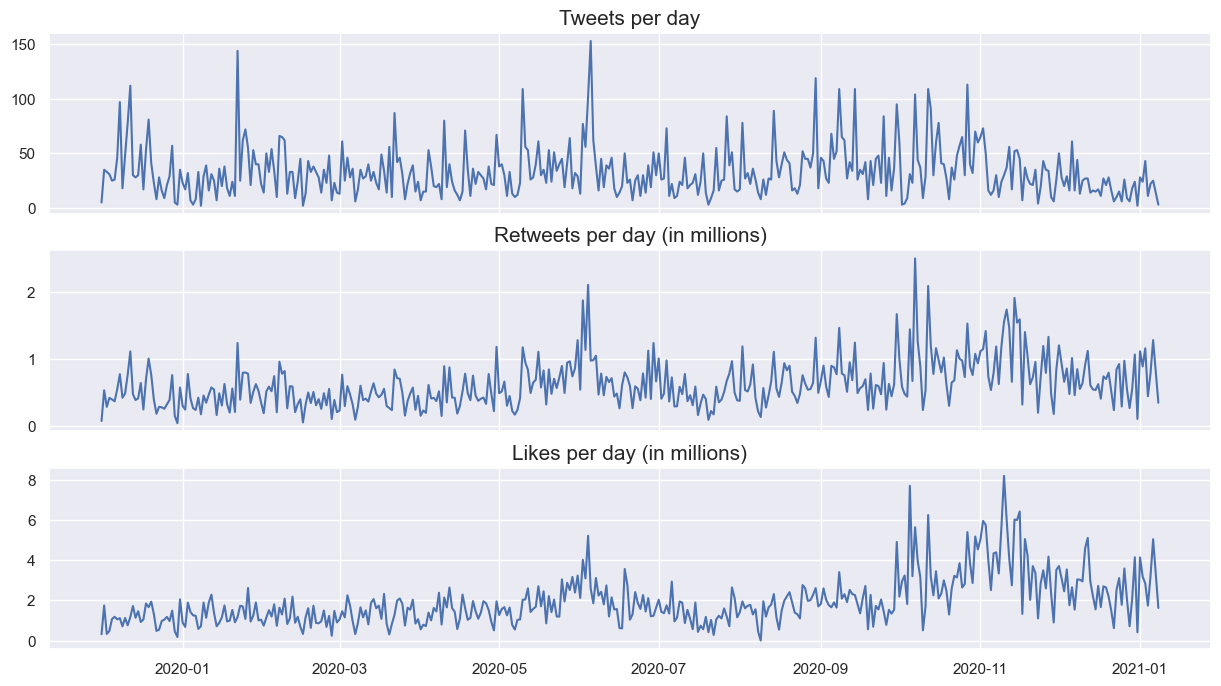

In [8]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)

axes[0].plot(data['date'], data['per_day_tweets'])
axes[0].set_title('Tweets per day', size=15)
axes[1].plot(data['date'], data['per_day_retweets']/10**6)
axes[1].set_title('Retweets per day (in millions)', size=15)
axes[2].plot(data['date'], data['per_day_likes']/10**6)
axes[2].set_title('Likes per day (in millions)', size=15)

plt.show()

Let's have an idea of the type of tweets we have :

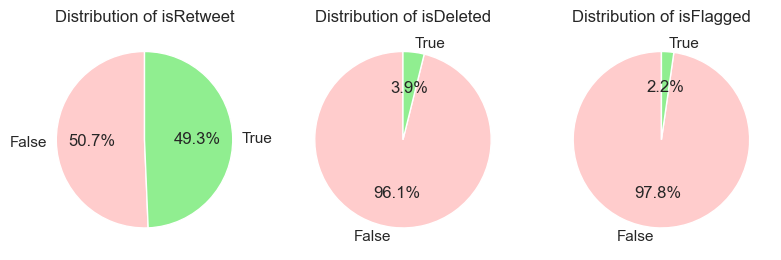

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 12))

variables = ['isRetweet', 'isDeleted', 'isFlagged']
colors = ['#FFCCCC', 'lightgreen']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.pie(data[var].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


There are very few deleted tweets, though this can be an indication of misinformation spreaded by Trump.

Use spacy to get rid of stop words in the tweets. Stop words are all that words such as and, or, that, etc. that are not relevant for a tweet but are used very often.

In [10]:
#Before running following command install dictionary with:
#python -m spacy download en_core_web_sm

#download a english dictionary to make anlysis
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


In [11]:
#all tweets in one string
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])

#the text we have is too big to process it at once, so we split it into chunks
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

#manually clean text from links, punctuation, etc.
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)#remove links
clean= clean.translate(str.maketrans('', '', string.punctuation))#remove punctuation
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

Let's have a look at the most used words in Trump's tweets :

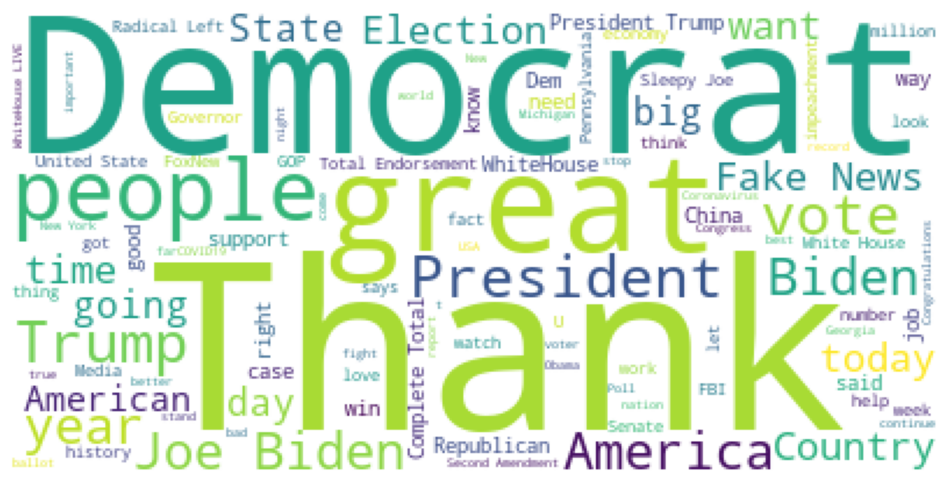

In [12]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

As we can see, there are not that much related to covid. Though one can already spot some of his favorite topics.

Let's focus our analysis on Covid-related tweets

In [13]:
#create a list of words related to covid
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

covid_related
False    12874
True       644
Name: count, dtype: int64

In [14]:
#data where covid_related is true
data_covid_rel = data[data['covid_related']==1]

Following the same process, we can have a look at the most used words in Trump's Covid related tweets :

In [15]:
#all tweets in one string
result_text = ' '.join(data_covid_rel['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])

#the text we have is too big to process it at once, so we split it into chunks
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

#manually clean text from links, punctuation, etc.
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)#remove links
clean= clean.translate(str.maketrans('', '', string.punctuation))#remove punctuation
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

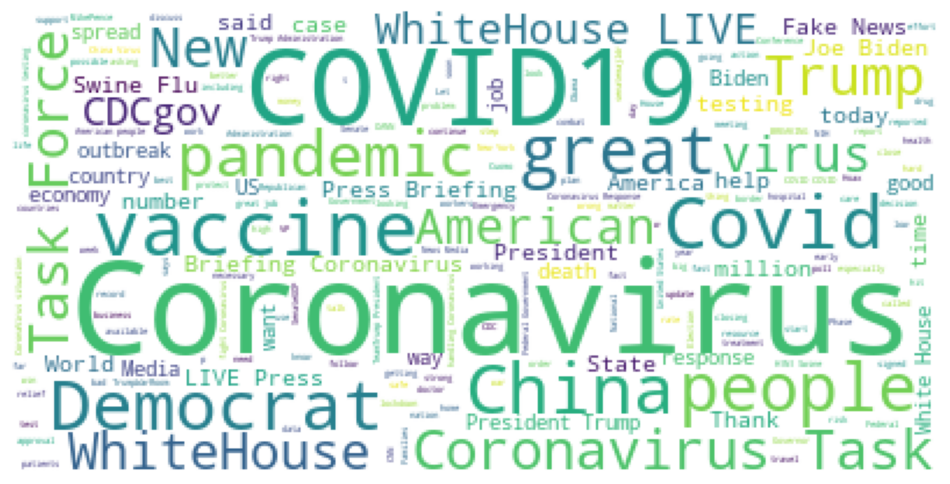

In [16]:
wordcloud = WordCloud(background_color="white").generate(clean)

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This image shows a more spreaded distribution of words. Though, one can spot the importance of china, vaccine or even swine flu in his tweets. Lots of words were also related to actions such as Task Force, Live Press or Briefing.

Let's find the moment when Trump tweeted the most about Covid:

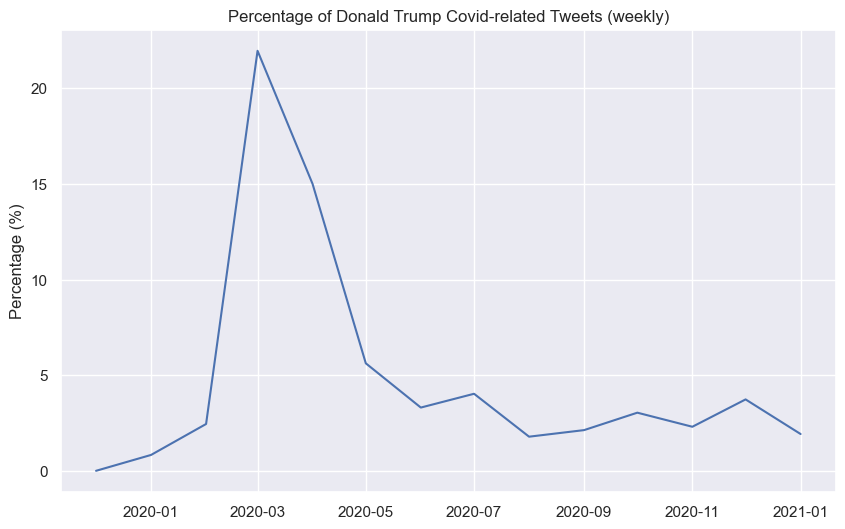

In [17]:
data['month_date'] = data.date.apply(lambda x: x.month)
data['year_date'] = data.date.apply(lambda x: x.year)
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: x.covid_related.sum() / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

#plot the percentage of covid related tweets
plt.figure(figsize=(10, 6)) 
plt.ylabel('Percentage (%)')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets (weekly)')
plt.show()

As we can see the highest density of covid related tweets is in March 2020, which is the beginning of the pandemic in the US. In March the percentage peaked at 20%. We can also see that the density of covid related tweets is decreasing over time.

Now let's discover if among the most retweeted and the most liked tweets there are some that are related to covid:

In [18]:
data['decile_retweeted'] = pd.qcut(data['retweets'], 10, labels=False, duplicates='drop')
data['decile_favorites'] = pd.qcut(data['favorites'], 10, labels=False, duplicates='drop')

Not all tweets have the same impact on public opinion, hence we want to see in which period covid related tweets were among the most relevant, to adress importance we use retweet as a proxy.

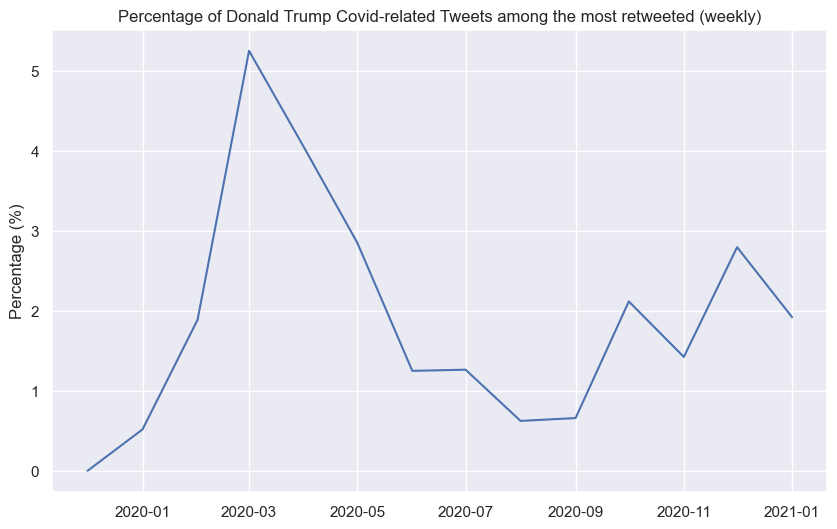

In [19]:
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: 
                                                                    ((x.covid_related)*((x.decile_retweeted==9)|(x.decile_retweeted==8)|(x.decile_retweeted==7)|
                                                                                        (x.decile_retweeted==6)|(x.decile_retweeted==5))).sum() 
                                                                                        / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

plt.figure(figsize=(10, 6)) 
plt.ylabel('Percentage (%)')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets among the most retweeted (weekly)')
plt.show()

**As we can see the moment were we had the highest share of covid related tweets (March 2020) is also the moment we had also the highest number of tweets related to covid.**

# Causal Impact Analysis

In one of our analysis, we are interested in finding a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine on Wikipedia. During COVID-19 period Trump claimed that Hydroxychloroquine was a cure for COVID-19, this claim was not supported by scientific evidence. 

Initially we will do a preliminary graphical analysis looking at the number of visits to the page of Hydroxychloroquine on Wikipedia. We will plot the time series and draw a red line everytime Trump tweeted about Hydroxychloroquine.

After a the preliminary analysis, we will use  the [Causal Impact](https://google.github.io/CausalImpact/CausalImpact.html) library in Python to perform a test which can tell us if there is a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine.
To run this analysis we need to build a dataframe with the following columns:
- data index: the date of the observation of our time series.
- y: the number of visits to the the page of Hydroxychloroquine (test variable).
- x: the number of visits to the page of Baricitinib, a drug that was used to treat Covid-19 and that was not mentioned by Trump(control variable).

The Causality assumptions need to be verified:
- The x is not affected by the intervention (Trump's tweets) but they are correlated to y.
- The correlation between y and x should not be affected by the intervention.

We decided to take Baricitinib as a control because it is a drug used as anti-rheumatoid and that was not mentioned by Trump. We assume that the number of visits to the page of Baricitinib is not affected by Trump's tweets but it is correlated to the number of visits to the page of Hydroxychloroquine, since both drugs are used to treat rheumatoid arthritis.

Let's see the number of tweets where Hydroxychloroquine is mentioned:

In [20]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# create a new column with the result of the analysis
new_col = analyze.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', data['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [21]:
# get the dates where trump spoke about Hydroxychloroquine
critical_data_hydro = data[data['Hydroxychloroquine'] == True]['date']
week_critical_data_hydro = (critical_data_hydro - pd.to_timedelta((critical_data_hydro.dt.dayofweek+1) % 7, unit='D')).unique()

We want to get from wikipedia and from Google Trends the number of pageviews for the article related to Hydroxychloroquine. We want to graphically inspect the variation of visits number over time and see if Trump's tweets had an impact on the number of visits.

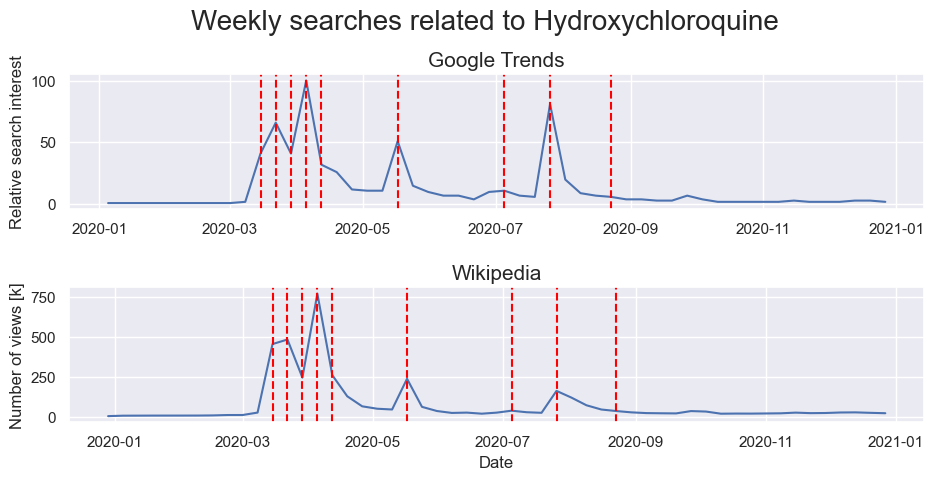

In [22]:
pagename = 'Hydroxychloroquine'
folder = 'extra_material'
filename = 'hydroxychloroquine'

weekly_wikipedia_hydro_df, daily_wikipedia_hydro_df = load_wikipedia_df(pagename,filename)
gtrends_hydro_df = load_gtrend_df(pagename, filename)

daily_wikipedia_hydro_df = daily_wikipedia_hydro_df.drop('Week', axis=1)
daily_wikipedia_hydro_df

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_hydro_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_hydro_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]
axis[1].set_xlabel('Date')

plt.show()

As we can see the Wikipedia and Google trend pageviews behave simarly, Google Trends, uses a relative scale from 0 to 100 while Wikipedia returns the absolute number of visits. We can see that the number of visits was almost zero until march 2020. The spikes in the graph appear almost at the same time with Trump's Tweet. We should further investigate if there is a causal relationship between Trump's tweets and the number of visits. 

Let's follow the same procedure for Baricitinib:

In [23]:
ci_hydro_df = daily_wikipedia_hydro_df.copy()
ci_hydro_df = ci_hydro_df.rename(columns = {'Views' :'y'})
stop_date_hydro = week_critical_data_hydro[0]
print('First time Trump talked about Hydroxychloroquine: ', stop_date_hydro)

pagename = 'Baricitinib'
filename = 'baricitinib'

weekly_wikipedia_baricitinib_df, daily_wikipedia_baricitinib_df = load_wikipedia_df(pagename, filename)
gtrends_baricitinib_df = load_gtrend_df(pagename, filename)

daily_wikipedia_baricitinib_df = daily_wikipedia_baricitinib_df.drop('Week', axis=1)


ci_hydro_df['x'] = daily_wikipedia_baricitinib_df

First time Trump talked about Hydroxychloroquine:  2020-03-15 00:00:00


To perform the test check if the hypothesis for causal impact analysis are satisfied:

In [24]:
ci_hydro_df[:stop_date_hydro].corr()

,y,x
y,1.000000,0.575105
x,0.575105,1.000000


In [25]:
ci_hydro_df[stop_date_hydro:week_critical_data_hydro[-1]].corr()

,y,x
y,1.000000,0.176224
x,0.176224,1.000000


The correlation between y and x should not be affected by the intervention, we see that is not the case, however. To relax this assumption we will therefore include [dynamic time-varying regression coefficients](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/41854.pdf), which account for time-varying relationships.

Still, given the fairly week correlation between the response and the control time series, our results of our analysis should be interpreted with caution.

In [26]:
critical_data_hydro = pd.to_datetime(critical_data_hydro)

In [27]:
pre_period = [ci_hydro_df.index[0], critical_data_hydro.iloc[0]]
post_period = [critical_data_hydro.iloc[1], critical_data_hydro.iloc[-1]]
print(pre_period, post_period)

[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-03-21 00:00:00')] [Timestamp('2020-03-24 00:00:00'), Timestamp('2020-08-24 00:00:00')]


Now we can run the causal impact analysis:

/Users/Etienne/opt/miniconda3/envs/ada/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Etienne/opt/miniconda3/envs/ada/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: standardize, nseasons. After release 0.14, this will raise.
  warnings.warn(
/Users/Etienne/opt/miniconda3/envs/ada/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users

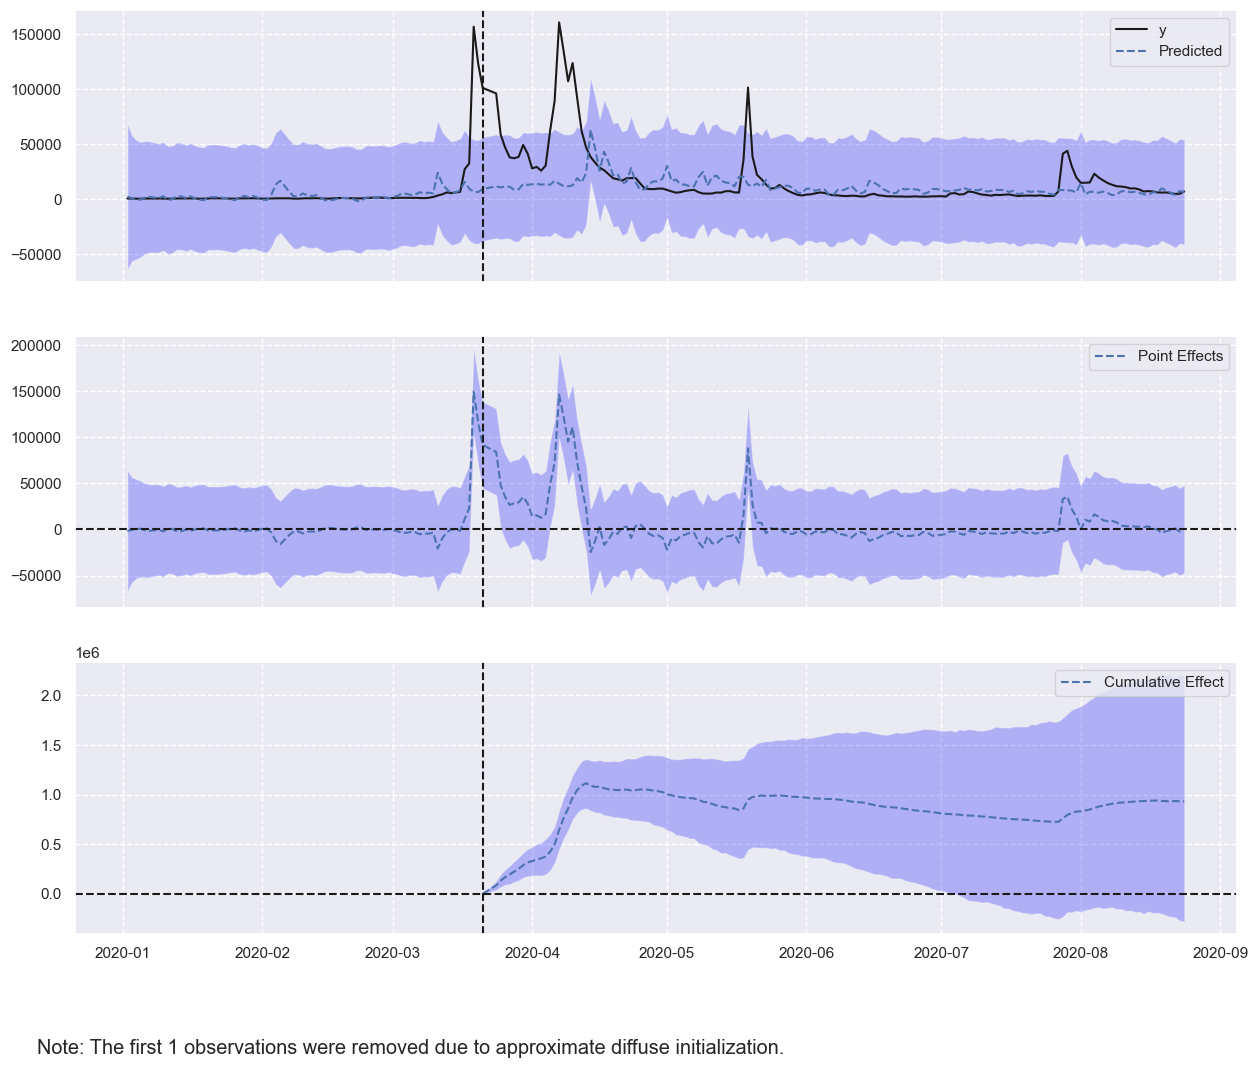

In [28]:
impact = CausalImpact(data = ci_hydro_df, pre_period=pre_period, post_period=post_period)
impact.plot()

In [29]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    17862.1            2750764.0
Prediction (s.d.)         11802.74 (4105.69) 1817622.22 (632276.07)
95% CI                    [3589.89, 19683.9] [552843.26, 3031319.9]

Absolute effect (s.d.)    6059.36 (4105.69)  933141.78 (632276.07)
95% CI                    [-1821.79, 14272.21][-280555.9, 2197920.74]

Relative effect (s.d.)    51.34% (34.79%)    51.34% (34.79%)
95% CI                    [-15.44%, 120.92%] [-15.44%, 120.92%]

Posterior tail-area probability p: 0.08
Posterior prob. of a causal effect: 92.21%

For more details run the command: print(impact.summary('report'))


Looking at the graph it seems that immediately after the intervention the number of visits to the page of Hydroxychloroquine increased, however the confidence intervals are very wide and we cannot conclude that there is a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine. This graph could suggest us that the analysis we want to undertake could be unfruitful. During Milestone 3 we could try to find a better control variable and see if we can find a causal relation between Trump's tweets and the number of visits to the page of Hydroxychloroquine, or enlarge the analysis to other fake news. We could also add some important interventions of Donald Trump's on TV, as some of his fake news were originally announced on live. This might help when studying the beginning of the trend.

As hydroxychloroquine  was not the only fake news spread by Trump, we repeated the same preliminary analysis and visualizations for other fake news, to get a better idea of how well our observations for hydroxychloroquine generalize to other topics.

### 1)  Swine Flu

Trump was tweeting a lot about Swine Flu to attack the democrats, one can study if he was resurging a trend:

Number of tweets talking about Swine Flu is:  26


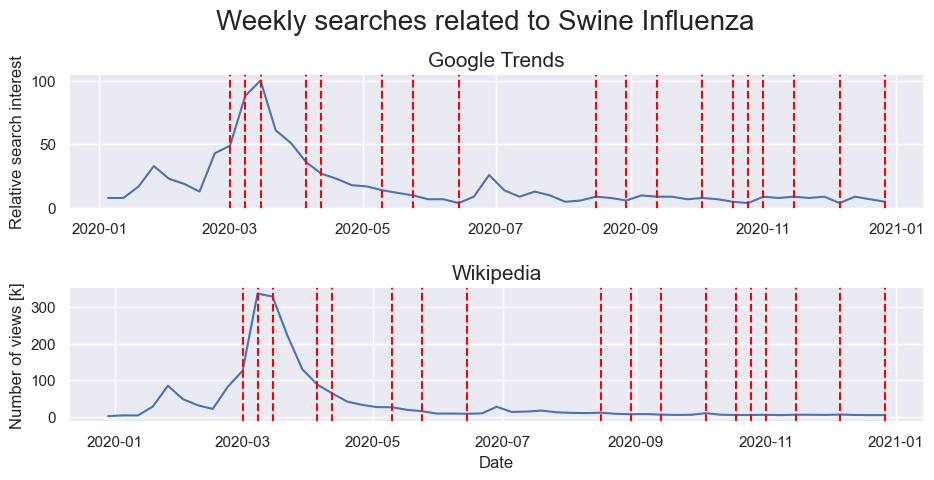

In [30]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col
print('Number of tweets talking about Swine Flu is: ', data['Swineflu'].sum())

# get the dates where trump spoke
critical_data = data[data['Swineflu'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'Swine Influenza'
filename = 'swineflu'

weekly_wikipedia_df, _ = load_wikipedia_df(pagename, filename)
gtrends_df = load_gtrend_df(pagename, filename)

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]
axis[1].set_xlabel('Date')

plt.show()

From the plot, it seems that peaks in popularity tend to start before Trump's tweets (especially the first two), but some of Trump's tweets might still have had some effect. His first tweet seemed to have increased the slope of the main popularity peak, and his tweets in mid-june 2020 might have cause the subsequent peak in interest (a smaller one, but Trump's tweet clearly precedes it this time).

### 2)  China Laboratory-Leak Virus

Trump was not tweeting directly about the fact that covid escaped from a lab, however, he tweeted a lot about the "China Virus", did this feed the trend?

Number of tweets talking about COVID-19 lab leak theory is:  44


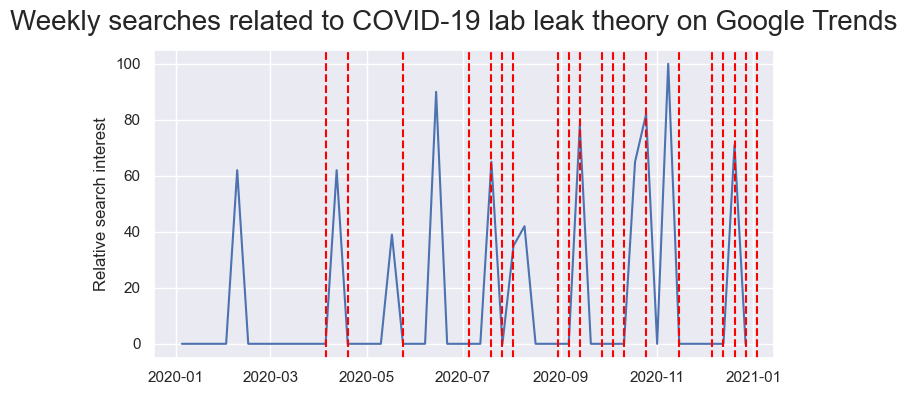

In [31]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus', 'China Virus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())

# get the dates where trump spoke
critical_data = data[data['Leaktheory'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'COVID-19 lab leak theory'
filename = 'leaktheory'

weekly_wikipedia_df, _ = load_wikipedia_df(pagename, filename)
gtrends_df = load_gtrend_df(pagename, filename)

plt.figure(figsize=(8, 4)) 

plt.suptitle('Weekly searches related to {pagename} on Google Trends'.format(pagename=pagename), size=20)

plt.ylabel('Relative search interest')
plt.plot(gtrends_df['Views'])
[plt.axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

plt.show()

For the 'Lab Leak Theory' the graph is much more hectic and it's hard to conclude on any causal effect of Trump's tweets on online trends.

### Granger causality test

Our causal impact analysis has shown that Trump's tweets and online trends were often related, especially for hydroxychloroquine for instance. It was, however, sometimes difficut to establish whether Trump's tweet preceded the trends. To investigate this, we chose to conduct [Granger causality]() tests. "The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another".

The [null hypothesis](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html) is that "the the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1".

In [32]:
# Put the tweets in a format compatible with Granger causality analysis (i.e. time series)
tweets_hydro_timeseries_df = pd.DataFrame(index=gtrends_hydro_df['Views'].index, columns=['Date'])

for date in week_critical_data_hydro:
    tweets_hydro_timeseries_df[date] = (tweets_hydro_timeseries_df.index == date).astype(int)

tweets_hydro_timeseries_df['Date'].fillna(0, inplace=True)
tweets_hydro_timeseries_df['Tweet'] = tweets_hydro_timeseries_df.iloc[:, 1:].sum(axis=1)

# Combine gtrends and tweets
gtrends_tweets_hydro_df = gtrends_hydro_df.copy()
gtrends_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']

# Combine wiki and tweets
wiki_tweets_hydro_df = weekly_wikipedia_hydro_df.copy()
wiki_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']
wiki_tweets_hydro_df['Tweets'].fillna(0, inplace=True)

Let's start with a Granger test checking whether Google Trends views caused tweets or vice versa.

In [33]:
# Granger test between GTrends views and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print("DO VIEWS CAUSE TWEETS?")
grangercausalitytests(gtrends_tweets_hydro_df, 2)

print('\n --------------------------------')
print("\n DO TWEETS CAUSE VIEWS?")
tweets_cause_views_gtrends = grangercausalitytests(gtrends_tweets_hydro_df[['Tweets', 'Views']], 2)

DO VIEWS CAUSE TWEETS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4121  , p=0.1270  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=2.5628  , p=0.1094  , df=1
likelihood ratio test: chi2=2.5005  , p=0.1138  , df=1
parameter F test:         F=2.4121  , p=0.1270  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9774  , p=0.3841  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=2.1720  , p=0.3376  , df=2
likelihood ratio test: chi2=2.1262  , p=0.3454  , df=2
parameter F test:         F=0.9774  , p=0.3841  , df_denom=45, df_num=2

 --------------------------------

 DO TWEETS CAUSE VIEWS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9602  , p=0.0523  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=4.2077  , p=0.0402  , df=1
likelihood ratio test: chi2=4.0431  , p=0.0444  , df=1
parameter F test:         F=3.9602  , p=0.0523  , df_denom=48, df_num=1

Granger Causalit

The p-values for Views causing Tweets is above 0.05 by a margin, so no signficance there.
The p-values for Tweets causing Views are around 0.05, however: so the causality is just barely significant - Trump might indeed have an impact on Tweets.

Let's redo the test with Wikipedia pageviews.

In [34]:
# Granger test between Wikipedia pageviews and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print("DO VIEWS CAUSE TWEETS?")
grangercausalitytests(wiki_tweets_hydro_df, 2)

print('\n \n --------------------------------')
print("\n \n DO TWEETS CAUSE VIEWS?")
tweets_cause_views_wiki = grangercausalitytests(wiki_tweets_hydro_df[['Tweets', 'Views']], 2)

DO VIEWS CAUSE TWEETS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1650  , p=0.1476  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=2.2976  , p=0.1296  , df=1
likelihood ratio test: chi2=2.2483  , p=0.1338  , df=1
parameter F test:         F=2.1650  , p=0.1476  , df_denom=49, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7117  , p=0.4961  , df_denom=46, df_num=2
ssr based chi2 test:   chi2=1.5782  , p=0.4543  , df=2
likelihood ratio test: chi2=1.5542  , p=0.4597  , df=2
parameter F test:         F=0.7117  , p=0.4961  , df_denom=46, df_num=2

 
 --------------------------------

 
 DO TWEETS CAUSE VIEWS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6313 , p=0.0013  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=12.3434 , p=0.0004  , df=1
likelihood ratio test: chi2=11.0755 , p=0.0009  , df=1
parameter F test:         F=11.6313 , p=0.0013  , df_denom=49, df_num=1

Granger Caus

The results are much more marked now: the p-values for Tweets causing Views are well below the threshold of 0.05 - Trump's tweets seemed to have an impact on Wikipedia pageviews.

___
## Part 2: Causal Impact Analyis of Alternative Hypotheses
We studied how Trump's tweet can affect the public debate. This part proposes to perform a causal impact analysis on alternative hypothesis. To do so, we'll study the effect of discrete event on our topics (mobility changepoints and public events in the US) and use the total trafic on Wikipedia as a time serie baseline.

The following part is reusing code and helper functions from the work [Sudden Attention Shifts on Wikipedia During the COVID-19 Crisis](https://github.com/epfl-dlab/wiki_pageviews_covid)

In [35]:
params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False
}

mpl.rcParams.update(params)

In [36]:
interventions = load_interventions("extra_material/wiki_pageviews_covid/data/interventions.csv")
topics_df, topics = load_topics('extra_material/wiki_pageviews_covid/data/topics_linked.csv.xz')
agg = load_aggregated("extra_material/wiki_pageviews_covid/data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
dfs_pca_shift = load_pca(codes_order, pca_folder="extra_material/wiki_pageviews_covid/data/pca/")

The following plot shows the evolution of pageview on wikipedia, and the amount of them related to covid. We'll superimpose the trends on Hydroxichloroquine to spot a potential correlation. Note that since the covid fighting strategies differed from a state to another, we enriched the dataset with the date of first school closure, or first lockdown in the US.

ValueError: keyword up is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

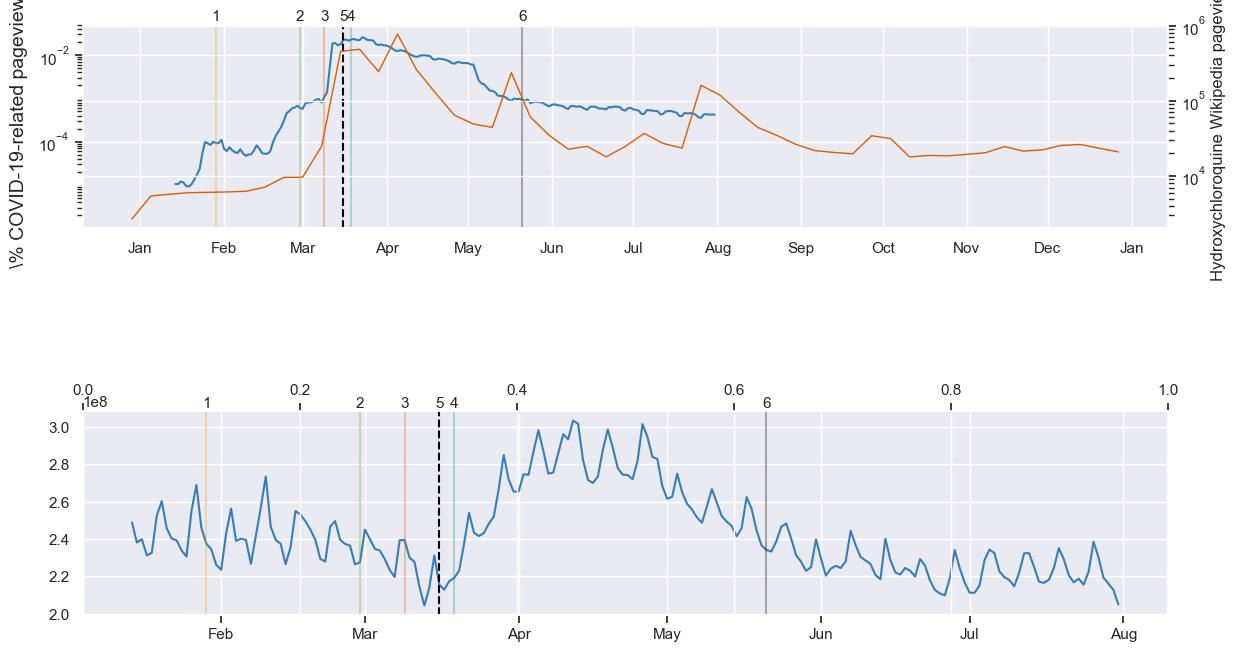

In [72]:
idx =3
fig, axs = plt.subplots(2, 1,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})
# COVID-RELATED PAGEVIEWS
ax = axs[0]
code = codes_order[idx]
ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
start, end = plot_dates(ax, 20200114, 20200731, 
                        agg[code]["sum"].index,
                        (agg[code]["covid"]["sum"].values + agg[code + ".m"]["covid"]["sum"].values +1) 
                        / (agg[code]["sum"].values + agg[code+".m"]["sum"].values),  sci=False, color="#377eb8")

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)


ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.set_ylabel("\% COVID-19-related pageviews", rotation=90,labelpad=14.0)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.set_yscale("log")
ax.set_ylim([10**(-6), 5* 10**(-2)])
ax.set_yticks([10**(-4), 10**(-2)])

ax02 = ax.twinx() 
ax02.set_ylabel('Hydroxychloroquine Wikipedia pageviews') 
ax02.plot(weekly_wikipedia_hydro_df['Views'], color='#d95f02', linewidth=1)
ax02.set_yscale('log')
ax02.tick_params(axis ='y') 

# NON COVID-RELATED PAGEVIEWS
ax = axs[1]

ax_twin = ax.twiny()

start, end = plot_dates(ax, 20200114, 20200731, 
                    agg[code]["sum"].index, agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
                    agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values, 
                        color="#377eb8", sci=False)

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
ax.tick_params(up = False)

for ax_t in [ax, ax_twin]:
    ax_t.spines['left'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    ax_t.yaxis.set_ticks_position('right')

ax.set_ylabel("Number of pageviews not\n related to COVID-19 ")

ax12 = ax.twinx() 
ax12.set_ylabel('Hydroxychloroquine Wikipedia pageviews') 
ax12.plot(weekly_wikipedia_hydro_df['Views'], color='#d95f02', linewidth=1)
ax12.tick_params(axis ='y') 

#General labels:
axs[0].set_title("\% COVID-19-related pageviews and evolution of Hydroxychloroquine Wikipedia pageviews:",pad=35)
axs[1].set_title("Number of pageviews not related to COVID-19 and evolution of Hydroxychloroquine Wikipedia pageviews:",pad=35)

lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color='#d95f02', lw=1.5, ls="-"),
    Line2D([0], [0], color="black", lw=1.5, ls=":")
]

axs[0].legend(
    handles=lines,
    labels=["Pageviews","Hydroxychloroquine Wikipedia pageviews"],
    loc='upper center', bbox_to_anchor=(0.3, 2),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=13
)
lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.) 
                for x, _ in interventions_helper.items()]

axs[1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v, 
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='upper center', bbox_to_anchor=(.5,3.7),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=12
)


Both plots allows to visually correlate interventions and online searches. For example, as we can observe, the first mobility changepoint have an important impact on online searches, and represent the time were searches were related to covid were maximum. This interventions will be used right below in Granger cauality test to assess their imp

As we can see, Hydroxychloroquine topic pageviews seems to follow the global trend of topics related to covid with more local peaks. These series will be compared right after in a causal analysis.

Pageviews of topic not related to covid could be used as a baseline series showing the increase of online traffic. This could be used in a future analysis.

### Causal Impact

To further investigate the observations made above, let's start by conducting a Causal Impact study, similar to what we did in Part 1.B) of an event that visually seems to have influenced Wikipedia pageviews for hydroxychloroquine: the mobility changepoint.

The start of the postperiod is set to the mobility changepoints in the US.

In [38]:
date_restriction = pd.to_datetime('2020-03-16')
date_restriction

Timestamp('2020-03-16 00:00:00')

And the end of the postperiod is set to the normality changepoint, which we thought marked a post-postperiod in a sense, which we wanted to avoid.

In [39]:
date_normality = pd.to_datetime('2020-05-21')
date_normality

Timestamp('2020-05-21 00:00:00')

In [40]:
ci_hydro_df.head()

,y,x
Date,,
2020-01-01,547,40
2020-01-02,793,84
2020-01-03,717,71
2020-01-04,616,43
2020-01-05,563,40


Again, let's assess whether the assumptions of correlatedness hold for the pre- and post-period.

In [41]:
ci_hydro_df[:date_restriction].corr()

,y,x
y,1.000000,0.578258
x,0.578258,1.000000


In [42]:
ci_hydro_df[date_restriction:date_normality].corr()

,y,x
y,1.000000,-0.208032
x,-0.208032,1.000000


Similarly as in our previous causal analysis study, the correlation is not particularly strong, and above all it is time-varying, which is why we will be using dynamic time-varying regression coefficients again.

In [43]:
pre_period = [ci_hydro_df.index[0], date_restriction]
post_period = [date_restriction + timedelta(days=1), date_normality]
print(pre_period, post_period)

[Timestamp('2020-01-01 00:00:00'), Timestamp('2020-03-16 00:00:00')] [Timestamp('2020-03-17 00:00:00'), Timestamp('2020-05-21 00:00:00')]


/Users/Etienne/opt/miniconda3/envs/ada/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Etienne/opt/miniconda3/envs/ada/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: standardize, model_args, nseasons. After release 0.14, this will raise.
  warnings.warn(
/Users/Etienne/opt/miniconda3/envs/ada/lib/python3.9/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWar

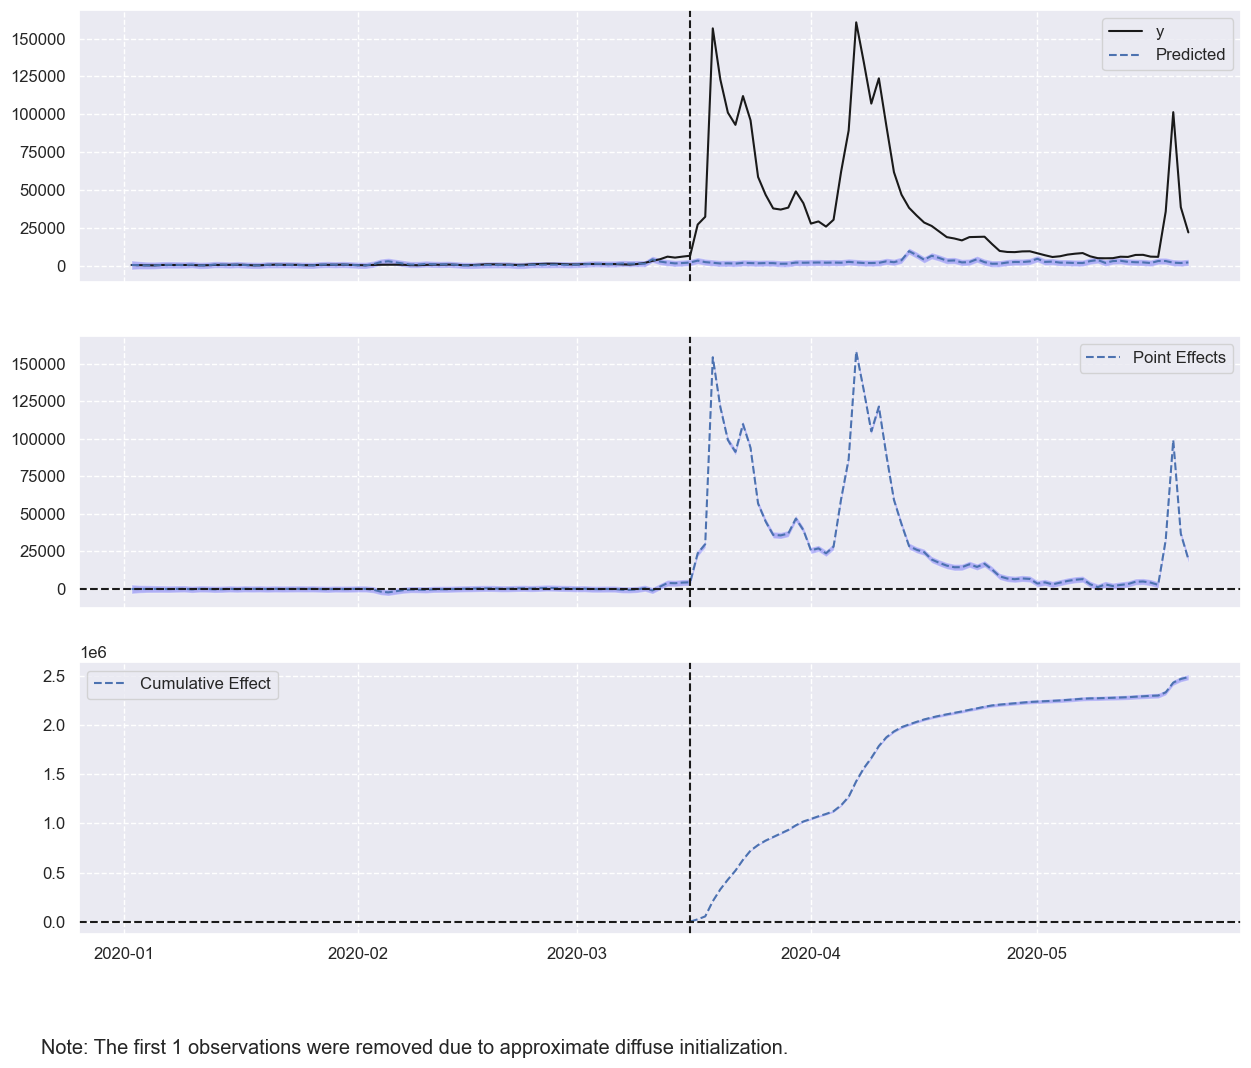

In [44]:
impact = CausalImpact(data=ci_hydro_df, pre_period=pre_period, post_period=post_period, model_args={'dynamic_regression': True})
impact.plot()

The plot clearly shows a strong causal impact of the mobility changepoints on pageviews: the changepoint precedes the big peaks in hydroxychloroquine views which were not apparent in searches for searches of the control timeseries. The confidenc intervals are furthermore very tight.

We should however be cautious when interpreting these results, as the correlation between the control and response time series is not so strong.

### Granger Causality

Finally, let's conduct a Granger causality test to see whether interventions (e.g. first Covid case) in the US could have caused trends in hydroxychloroquine views on Google.

In [45]:
# Put the interventions in a format compatible with Granger causality analysis (i.e. time series)
interventions_us_dates = pd.Series(interventions['en'].values())
interventions_us_dates_weekly = (interventions_us_dates - pd.to_timedelta((interventions_us_dates.dt.dayofweek+1) % 7, unit='D')).unique()

interventions_hydro_timeseries_df = pd.DataFrame(index=gtrends_hydro_df['Views'].index, columns=['Date'])

for date in interventions_us_dates_weekly:
    interventions_hydro_timeseries_df[date] = (interventions_hydro_timeseries_df.index == date).astype(int)

interventions_hydro_timeseries_df['Date'].fillna(0, inplace=True)
interventions_hydro_timeseries_df['Interventions'] = interventions_hydro_timeseries_df.iloc[:, 1:].sum(axis=1)

# Combine gtrends and interventions
gtrends_interventions_hydro_df = gtrends_hydro_df.copy()
gtrends_interventions_hydro_df['Interventions'] = interventions_hydro_timeseries_df['Interventions']

gtrends_interventions_hydro_df.head()

,Views,Interventions
Date,,
2020-01-05,1,0
2020-01-12,1,0
2020-01-19,1,0
2020-01-26,1,1
2020-02-02,1,0


In [51]:
print("DO INTERVENTIONS CAUSE VIEWS?")
interventions_cause_views = grangercausalitytests(gtrends_interventions_hydro_df[['Interventions', 'Views']], 1 )

DO INTERVENTIONS CAUSE VIEWS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3447  , p=0.2519  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=1.4288  , p=0.2320  , df=1
likelihood ratio test: chi2=1.4091  , p=0.2352  , df=1
parameter F test:         F=1.3447  , p=0.2519  , df_denom=48, df_num=1


p-values are well above 0.05: the null hypothesis is sufficient to explain the timeseries. That is in contrast with the results we obtained with Trump's tweets, which did seem to cause shifts in online trends.

# Conclusion

This notebook presented our milestone 2 as part of our final project. After having presented our dataset, we proposed different type of causal analysis that can be carried out to assess Donald Trump's influence. Based on TAs feedbacks, we will consolidate this method for our final project's milestone. 